Obtain bathymetric data. You can use public datasets such as NOAA's ETOPO1. Download the data from: https://www.ngdc.noaa.gov/mgg/global/ and select the "ETOPO1 Global Relief Model" dataset.

In [103]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.cm as cm
from matplotlib import gridspec

import datetime
from datetime import datetime, timedelta
import os
import random
import seaborn as sns


%matplotlib inline

from pprint import pprint

import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature


import cmocean

from mpl_toolkits.mplot3d import Axes3D

from timeit import default_timer as timer
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, Delaunay
from scipy.interpolate import interp2d
from scipy import spatial
from glob import glob

import gsw


In [10]:
da_map = xr.open_dataset('/d1/mengyang/Benguela/Annette_paper/ETOPO_2022_v1_60s_N90W180_bed.nc')

lon_min, lon_max = 14, 20
lat_min, lat_max =  -35, -29

da_sub = da_map.sel(lat=slice(lat_min, lat_max), lon= slice(lon_min, lon_max))

# SHB map

In [263]:
da = xr.open_mfdataset('/d1/mengyang/Benguela/Particle_tracking/output_1km/avg_Y2012.nc')

tlong = da.lon_rho.values
tlat = da.lat_rho.values
mask = da.mask_rho.isel(time=0).values
inshore_mask = xr.where(da.isel(time=0).h <= 100, 1, 0)  # inshore of 100m
mask_sel = mask*inshore_mask

ocean_indices = np.where(mask_sel==1)
tlong_sel = tlong[ocean_indices]
tlat_sel = tlat[ocean_indices]

In [12]:
earlySHBML = pd.read_pickle('/d1/annette/Research/python/Manuscript/earlySHBML.pkl')

In [13]:
# construct data points
data_points = np.vstack((tlong_sel, tlat_sel)).T # shape of (13563, 2)

def clustering(num_polygons=75):
    
    np.random.seed(0)

    # Apply K-means clustering, run 20 times to get the best centroid seeds
    kmeans = KMeans(n_clusters=num_polygons, n_init=1)
    kmeans.fit(data_points)
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Initialize empty lists to store triangle vertices
    polygon_vertices = [[] for _ in range(num_polygons)]
    polygon_ind = [[] for _ in range(num_polygons)] # store the index in Atlantic POP grid

    # Post-processing to form polygons
    for i, label in enumerate(cluster_labels):
        polygon_vertices[label].append(data_points[i])
        polygon_ind[label].append(i)

    return polygon_vertices, polygon_ind, cluster_centers
    #polygon_vertices = np.array(polygon_vertices)  # all clusters' coordinates

In [14]:
polygon_vertices, polygon_ind, cluster_centers = clustering(1)

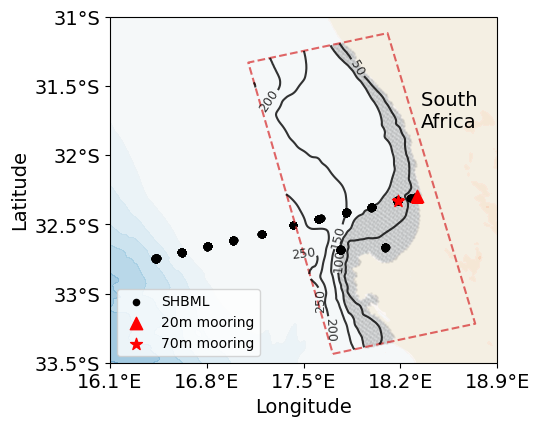

In [243]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

def plot_map(ax):
    ax.set_extent([17, 18.5, -33.5, -31], crs=ccrs.PlateCarree())

    ax.set_xticks(np.arange(16.1, 19.5, 0.7), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-33.5, -30.5, 0.5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  

    ax.add_feature(cfeature.LAND)

    colors = list(mcolors.TABLEAU_COLORS.values())
    ind_color = np.arange(len(colors)) # 0- 9

    edges_coord = []

    # water depth
    ca = da_sub.z.plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(), add_colorbar=False, alpha=0.5)
    #cbar = fig.colorbar(ca, ax=ax, label='Depth (m)', orientation='vertical', shrink=0.7)

    # edges
    corners_long = [tlong[0, 0], tlong[0, -1], tlong[-1, -1], tlong[-1, 0], tlong[0, 0]]
    corners_lat = [tlat[0, 0], tlat[0, -1], tlat[-1, -1], tlat[-1, 0], tlat[0, 0]]

    # Plot the corners and connect them
    ax.plot(corners_long, corners_lat, '--', color='C3', alpha=0.7, )

    # loop each cluster
    #for i in range(len(polygon_vertices)):
    for i in range(1):
        vertices = np.array(polygon_vertices[i])
        if len(vertices) >= 3:
            hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
            polygon = list(vertices[i] for i in hull.vertices.tolist() )
            polygon = np.array(polygon)

            #ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
            #edges_lon.append(np.append(polygon[:,0], polygon[0,0]))
            #edges_lat.append(np.append(polygon[:,1], polygon[0,1]))

            edges_coord.append(np.vstack((polygon, polygon[0])))
            #ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.2, transform=ccrs.PlateCarree())

            #ax.text(cluster_centers[i, 0]-0.05, cluster_centers[i, 1]-0.05,str(i+1), fontsize=15, alpha=0.6, color='k', transform=ccrs.PlateCarree())
            ax.scatter(vertices[:, 0], vertices[:, 1], c='gray', s=1, alpha=0.1, transform=ccrs.PlateCarree())

    ax.scatter(earlySHBML.Longitude, earlySHBML.Latitude, marker='o', s=20, color= 'k', transform=ccrs.PlateCarree(), label='SHBML')

    moor20m = [18.318, -32.292]
    ax.scatter(moor20m[0], moor20m[1], marker='^', color= 'r', s=80, transform=ccrs.PlateCarree(), label='20m mooring')

    # coordinate of 70 m mooring
    moor70m = [18.183, -32.329]
    ax.scatter(moor70m[0], moor70m[1], marker='*', color= 'r', s=80, transform=ccrs.PlateCarree(), label='70m mooring')

    # contour
    contours = ax.contour(da.lon_rho, da.lat_rho, da.isel(time=0).h, 
                          levels=5, colors='black', linewidths=1.5, alpha=0.8)
    plt.clabel(contours, inline=True, fontsize=9)

    ax.legend(loc='lower left', fontsize=10)

    ax.text(18.35, -31.8, 'South \nAfrica')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # da_giles = xr.open_dataset('/d1/mengyang/Benguela/SHBML/croco_grd.nc')
    # ax.scatter(da_giles.lon_rho, da_giles.lat_rho, marker='o', s=20, color= 'r', transform=ccrs.PlateCarree(), alpha=0.1)


    #fig.savefig('./figures/SHB_map_inshore100m.png', bbox_inches='tight', dpi=200)
plot_map(ax)

# O2 climatology

Pre-processing climatology data

In [16]:
# de Villier's climatology
fpath = '/d1/annette/Research/InsituData/Climatology_SBUS.csv'

df = pd.read_csv(fpath, encoding='latin1')

In [17]:
l_vars = list(df.columns) # names of all the variables
var = ['Temp', 'Sal', 'O2', '[PO4]3-', '[NO3]- + [NO2]-', 'Si(OH)4', 'Chl a']
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

In [18]:
def get_ds_stn(stn):
    '''for a station, return a dataset with all variables'''

    df_sub = df[df['Station'] == stn]
    # extract longitude and latitude
    depth = df_sub['Depth water [m]'].values # depth array
    num_depth = np.size(depth) # number of depth levels

    all_data = [] # collect data from all variables
    for v in var:
        #v = var[0] # the variable
        v_12months = np.empty((num_depth, 12)) # initialized the array for 12 months' data
        for i in range(12):
            # find the variable name that has both the variable and the month
            selected_var = [s for s in l_vars if (v in s) and (months[i] in s)][0]

            v_12months[:, i] = df_sub[selected_var].values
        all_data.append(v_12months)

    # form a dataset
    variables_dict = {f'{v}': (['depth', 'month'], d) for v, d in zip(var, all_data)}
    ds_ = xr.Dataset(
        variables_dict,
        coords={'month': np.arange(1,13,1),
                'depth': depth,
               },
    )
    ds_ = ds_.expand_dims({'station': [stn]})
    
    return ds_

In [19]:
# stitch all stations together
stations = df['Station'].unique()

ds = None
for stn in stations:  
    stn = int(stn) # needs to be int to be iterable
    try:
        ds = xr.concat([ds, get_ds_stn(stn)], 'station')    
    except:
        ds = get_ds_stn(stn)
ds = ds.rename({'Temp': 'temp', 
                'Sal': 'sal', 
                'O2': 'oxy',
                '[PO4]3-': 'phos',
                '[NO3]- + [NO2]-': 'nitrate', 
                'Si(OH)4': 'silicate', 
                'Chl a': 'chl', 
               })
# add units for each variable
units_dict = {'temp': 'degC',
              'depth': 'm',
              'sal': 'psu',
              'oxy': 'µmol/l',
              'phos': 'µmol/l',
              'nitrate': 'µmol/l',
              'silicate': 'µmol/l',
              'chl': 'µg/l'
             }

# Loop over variable names and set units
for var_name, units in units_dict.items():
    ds[var_name].attrs['units'] = units

In [20]:
ds

<xarray.Dataset>
Dimensions:   (depth: 366, station: 10, month: 12)
Coordinates:
  * depth     (depth) int64 5 6 7 8 9 10 11 12 ... 364 365 366 367 368 369 370
  * station   (station) int64 1 2 3 4 5 6 7 8 9 10
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (station, depth, month) float64 13.58 13.02 12.2 ... 7.68 7.84
    sal       (station, depth, month) float64 34.72 34.77 34.78 ... 34.53 34.53
    oxy       (station, depth, month) float64 232.2 232.7 180.9 ... 157.6 154.5
    phos      (station, depth, month) float64 1.66 1.45 2.01 ... 1.75 1.77 1.79
    nitrate   (station, depth, month) float64 12.7 13.0 14.46 ... 21.84 21.5
    silicate  (station, depth, month) float64 19.82 18.0 20.42 ... 19.52 20.0
    chl       (station, depth, month) float64 12.62 11.37 4.78 ... 0.1 0.1 0.1

In [21]:
df['Longitude'].unique(), df['Latitude'].unique(), df['Station'].unique()

(array([18.305 , 18.2747, 18.1788, 17.9953, 17.8107, 17.6082, 17.42  ,
        17.1942, 16.9885, 16.8045]),
 array([-32.309 , -32.3105, -32.3277, -32.372 , -32.4147, -32.4627,
        -32.5057, -32.5688, -32.6163, -32.6527]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

## Check some plots

In [25]:
# coords for stations
lat_ = df['Latitude'].unique()
lon_ = df['Longitude'].unique()

# distance from station 1
dist = np.cumsum(gsw.distance(lon_, lat_))/1000 # km
dist = np.insert(dist, 0, 0)

In [30]:
dist.shape, dist

((10,),
 array([  0.        ,   2.85243572,  12.06478071,  29.99226413,
         47.96327518,  67.7021284 ,  85.99086158, 108.29039036,
        128.27193828, 145.97077783]))

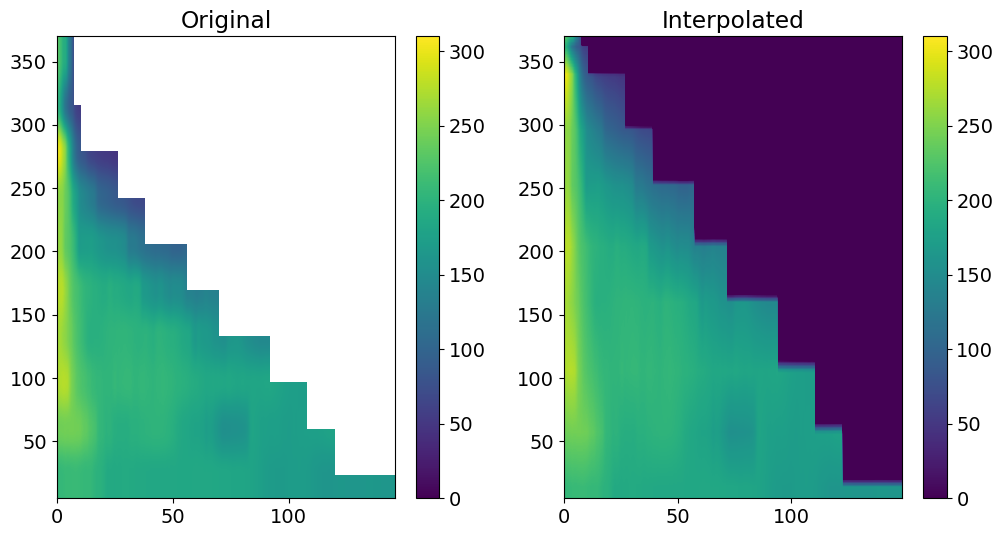

In [31]:
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

# Original data
A_ = ds.oxy.values[:,:,0]

A = np.nan_to_num(A_, nan=-999)

x_original = dist
y = ds.depth.values

# Create the interpolation function
f = interp2d(x_original, y, A.T, kind='linear')

# New x-axis
x_new = np.arange(0, 150)

# Interpolate A to the new grid
A_new = f(x_new, y).T

# Visualize the result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(A_, aspect='auto', extent=[x_original.min(), x_original.max(), y.min(), y.max()], vmin=0, vmax=310)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Interpolated")
plt.imshow(A_new, aspect='auto', extent=[x_new.min(), x_new.max(), y.min(), y.max()], vmin=0, vmax=310)
plt.colorbar()

plt.show()


In [32]:
import numpy as np

def detect_sharp_gradients(arr, threshold):
    
    '''replace the all values after the sharp gradient to NaN'''
    
    # Compute the gradient
    gradient = np.diff(arr)
    
    # Find the indices where the gradient exceeds the threshold
    sharp_points = np.where(np.abs(gradient) > threshold)[0]
    
    
    
    if sharp_points.size == 0:
        return arr
    else:
        arr[sharp_points[0]:] = np.nan
    #return sharp_points
        return arr


(370.0, 0.0)

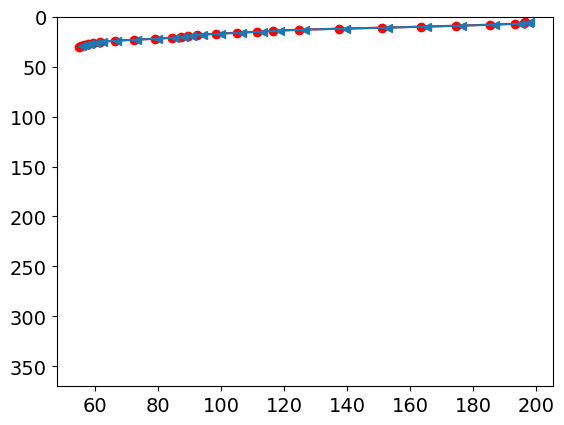

In [33]:
plt.plot( A_[1,:], ds.depth.values, color='r', marker='o')
# plt.plot( A_new[3,:], ds.depth, marker='<')
# plt.plot( A_new[20,:], ds.depth, marker='<')
# plt.plot( A_new[25,:], ds.depth, marker='<')
# plt.plot( A_new[30,:], ds.depth, marker='<')
plt.plot( detect_sharp_gradients(A_new[3,:], 15), ds.depth, marker='<')


plt.ylim(370, 0)

## Interpolate into a trasect with more profiles, every 1km

In [34]:
A_new_nan = np.empty((366, 150, 12))

for m in range(12):
    
    # Original data
    A_ = ds.oxy.values[:,:,m]
    A = np.nan_to_num(A_, nan=-999)
    x_original = dist
    y = ds.depth.values
    # Create the interpolation function
    f = interp2d(x_original, y, A.T, kind='linear')
    # New x-axis
    x_new = np.arange(0, 150)
    # Interpolate A to the new grid
    A_new = f(x_new, y)
    
    print(m, A_new.shape)


    for i in range(A_new.shape[1]):

        A_new_nan[:, i, m] = detect_sharp_gradients(A_new[:, i], 20)

0 (366, 150)
1 (366, 150)
2 (366, 150)
3 (366, 150)
4 (366, 150)
5 (366, 150)
6 (366, 150)
7 (366, 150)
8 (366, 150)
9 (366, 150)
10 (366, 150)
11 (366, 150)


In [35]:
DO_transect_interpolated = xr.Dataset(
    {
        'oxy': (['depth', 'dist2shore',  'month'], A_new_nan),

    },
    coords={
            'dist2shore': np.arange(0,150),
            'depth': ds.depth.values,
            'month': ds.month.values,
           },
)

In [36]:
#DO_transect_interpolated.to_netcdf('DO_transect_interpo.nc')

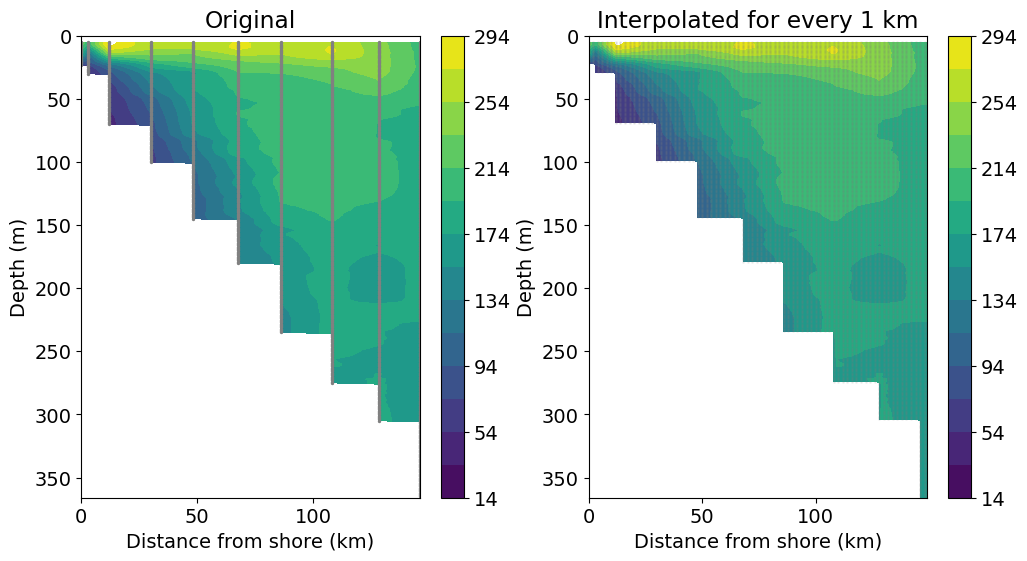

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(dist, ds.depth, ds.oxy.isel(month=0).T, levels=np.arange(14,302, 20))
plt.ylim(366,0)
plt.colorbar()
plt.xlabel('Distance from shore (km)')
plt.ylabel('Depth (m)')
plt.title('Original')

for stn in range(ds.station.size):
    ind = ~np.isnan(ds.oxy.isel(month=0, station=stn).values)
    x_ = ind*dist[stn]
    plt.scatter(x_[ind], ds.depth.values[ind], c='gray', s=2)



plt.subplot(1, 2, 2)
plt.contourf(DO_transect_interpolated.dist2shore, DO_transect_interpolated.depth, DO_transect_interpolated.oxy.isel(month=0), levels=np.arange(14,302, 20))
plt.ylim(366,0)
plt.colorbar()
plt.xlabel('Distance from shore (km)')
plt.ylabel('Depth (m)')
plt.title('Interpolated for every 1 km')

for stn in range(DO_transect_interpolated.dist2shore.size):
    if stn%2==0:
        ind = ~np.isnan(DO_transect_interpolated.oxy.isel(month=0, dist2shore=stn).values)
        x_ = ind*DO_transect_interpolated.dist2shore.values[stn]
        plt.scatter(x_[ind], DO_transect_interpolated.depth.values[ind], c='gray', s=1, alpha=0.1)

## Interpolate coordinates

In [38]:
# Original 1D array of longitudes with 12 elements
longitudes = df['Longitude'].unique() 
latitudes = df['Latitude'].unique()

# Create an array with 150 elements for the new grid
new_x = np.linspace(0, len(longitudes) - 1, 150)

interpolated_longitudes = np.interp(new_x, np.arange(len(longitudes)), longitudes)
interpolated_latitudes = np.interp(new_x, np.arange(len(latitudes)), latitudes)

Check if they match

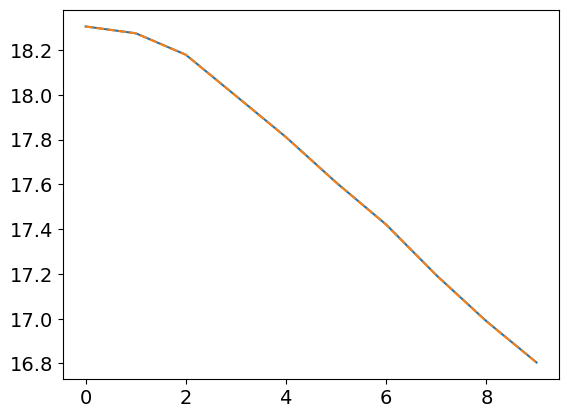

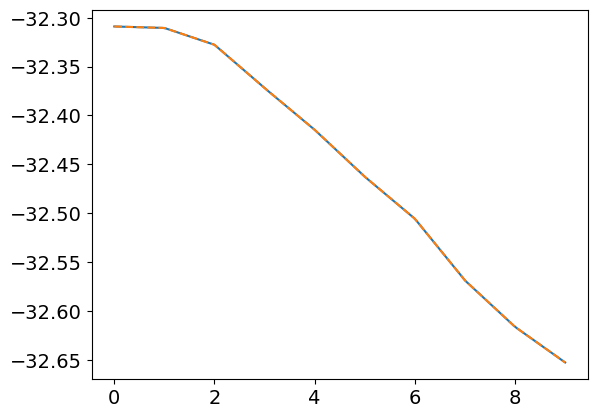

In [39]:
plt.plot(np.linspace(0, len(longitudes) -1 , 150), interpolated_longitudes)
plt.plot(np.linspace(0, len(longitudes) -1 , 10), longitudes, '--')

plt.figure()

plt.plot(np.linspace(0, len(longitudes) -1 , 150), interpolated_latitudes)
plt.plot(np.linspace(0, len(longitudes) -1 , 10), latitudes, '--')

Read model bathymetry

In [40]:
#da = xr.open_mfdataset('/d1/mengyang/Benguela/Particle_tracking/output_1km/avg_Y2012.nc')
da_giles = xr.open_mfdataset('/d1/mengyang/Benguela/SHBML/croco_grd.nc')

tlong = da_giles.lon_rho.values
tlat = da_giles.lat_rho.values
h = da_giles.h.values

In [41]:
# Target points
target_lons = interpolated_longitudes
target_lats = interpolated_latitudes

closest_indices = []

for lon_point, lat_point in zip(target_lons, target_lats):
    # Calculate the squared distance for efficiency
    distances = (tlong - lon_point)**2 + (tlat - lat_point)**2
    
    # Find the index of the minimum distance
    idx = np.unravel_index(np.argmin(distances), tlong.shape)
    
    closest_indices.append(idx)

print(closest_indices)

[(284, 124), (284, 124), (284, 124), (284, 124), (284, 124), (284, 124), (284, 124), (284, 124), (284, 123), (284, 123), (284, 123), (284, 123), (284, 123), (284, 123), (284, 123), (284, 123), (284, 123), (284, 122), (284, 122), (284, 121), (284, 121), (284, 121), (283, 120), (283, 120), (283, 120), (283, 119), (283, 119), (283, 118), (283, 118), (283, 118), (283, 117), (283, 117), (283, 116), (283, 116), (283, 115), (283, 114), (282, 114), (282, 113), (282, 112), (282, 111), (282, 110), (282, 110), (282, 109), (282, 108), (281, 107), (281, 106), (281, 105), (281, 105), (281, 104), (281, 103), (281, 102), (281, 101), (281, 100), (280, 100), (280, 99), (280, 98), (280, 97), (280, 96), (280, 95), (280, 94), (280, 94), (280, 93), (280, 92), (280, 91), (280, 90), (280, 89), (280, 89), (279, 88), (279, 87), (279, 86), (279, 85), (279, 84), (279, 83), (279, 82), (279, 81), (279, 81), (279, 80), (279, 79), (279, 78), (279, 77), (279, 76), (279, 76), (279, 75), (279, 74), (279, 73), (279, 73),

In [42]:
h_sel = []
for i in range(len(closest_indices)):
    h_sel.append(h[closest_indices[i]])
h_sel

[23.439419087458297,
 23.439419087458297,
 23.439419087458297,
 23.439419087458297,
 23.439419087458297,
 23.439419087458297,
 23.439419087458297,
 23.439419087458297,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 29.896071185121794,
 36.61554904749167,
 36.61554904749167,
 43.21792272403873,
 43.21792272403873,
 43.21792272403873,
 52.3433231753758,
 52.3433231753758,
 52.3433231753758,
 59.278440211164956,
 59.278440211164956,
 65.63804992865505,
 65.63804992865505,
 65.63804992865505,
 70.91705190849233,
 70.91705190849233,
 75.22327247594968,
 75.22327247594968,
 79.11871967163532,
 82.80781154308295,
 81.04702933740228,
 84.29760550877506,
 87.19450447463853,
 89.74722308536619,
 91.97347019025923,
 91.97347019025923,
 93.94315798826199,
 95.7702701319161,
 95.58300486601304,
 96.8432765276914,
 97.9375199526214,
 97.9375199526214,
 99.32910391151111,
 101.282

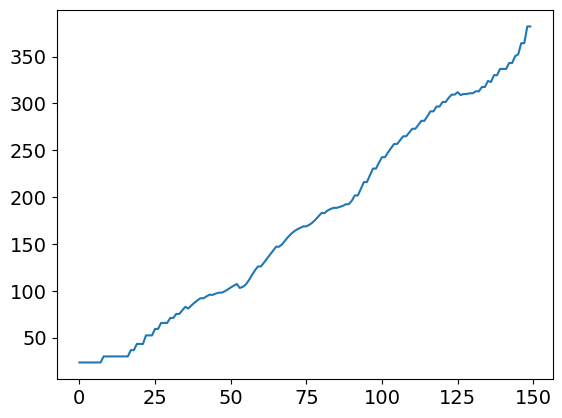

In [43]:
plt.plot(np.arange(150), h_sel)

Text(0, 0.5, 'Latitude')

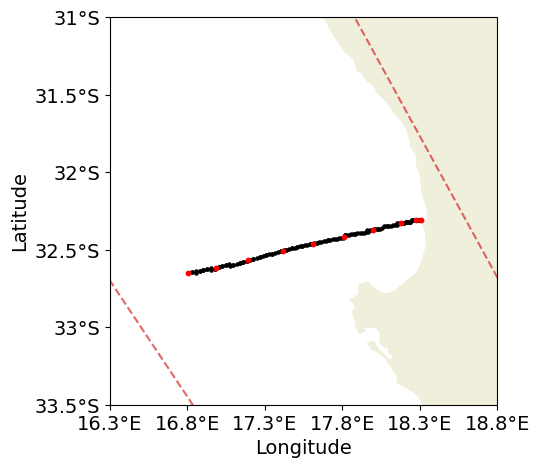

In [44]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([17, 18.5, -33.5, -31], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(16.3, 19, 0.5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-33.5, -30.5, 0.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  

ax.add_feature(cfeature.LAND)

# edges
corners_long = [tlong[0, 0], tlong[0, -1], tlong[-1, -1], tlong[-1, 0], tlong[0, 0]]
corners_lat = [tlat[0, 0], tlat[0, -1], tlat[-1, -1], tlat[-1, 0], tlat[0, 0]]
plt.plot(corners_long, corners_lat, '--', color='C3', alpha=0.7, )

for i in range(len(closest_indices)):
    ax.scatter(tlong[closest_indices[i]], tlat[closest_indices[i]],s=5, c='k', transform=ccrs.PlateCarree())
ax.scatter(longitudes, latitudes, s=10, c='r', transform=ccrs.PlateCarree())

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

## Now we have the h, we need to modify DO_transect_interpolated

In [45]:
DO_transect_interpolated

<xarray.Dataset>
Dimensions:     (depth: 366, dist2shore: 150, month: 12)
Coordinates:
  * dist2shore  (dist2shore) int64 0 1 2 3 4 5 6 ... 143 144 145 146 147 148 149
  * depth       (depth) int64 5 6 7 8 9 10 11 12 ... 364 365 366 367 368 369 370
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    oxy         (depth, dist2shore, month) float64 232.2 232.7 ... 157.6 154.5

In [46]:
arr_depth = DO_transect_interpolated.depth.values
print('first depth is ', arr_depth[0], ' m')

new_oxy = np.copy(DO_transect_interpolated.oxy.values)
num_d, num_i, num_t = new_oxy.shape
num_d, num_i, num_t

first depth is  5  m


(366, 150, 12)

In [47]:
for t in range(num_t):
    for i in range(num_i):
            DO_sel = new_oxy[:, i, t]
            
            # Count the number of non-NaN values
            count_non_nan = np.sum(~np.isnan(DO_sel))
            
            # this is the depth that has a value
            depth_with_value = arr_depth[0] + count_non_nan - 1 
            
            if depth_with_value <= int(h_sel[i]):
                
                # the depth range to append values
                diff_d = int(h_sel[i]) - depth_with_value
                
                new_oxy[count_non_nan : count_non_nan+diff_d, i, t] = DO_sel[count_non_nan-1]
                
            elif depth_with_value > int(h_sel[i]):
                
                # the depth range to append nan
                diff_d = - int(h_sel[i]) + depth_with_value
                
                new_oxy[count_non_nan - diff_d : count_non_nan, i, t] = np.nan


In [48]:
DO_transect_interpolated_final = xr.Dataset(
    {
        'oxy': (['depth', 'dist2shore',  'month'], new_oxy),

    },
    coords={
            'dist2shore': np.arange(0,150),
            'depth': ds.depth.values,
            'month': ds.month.values,
           },
)

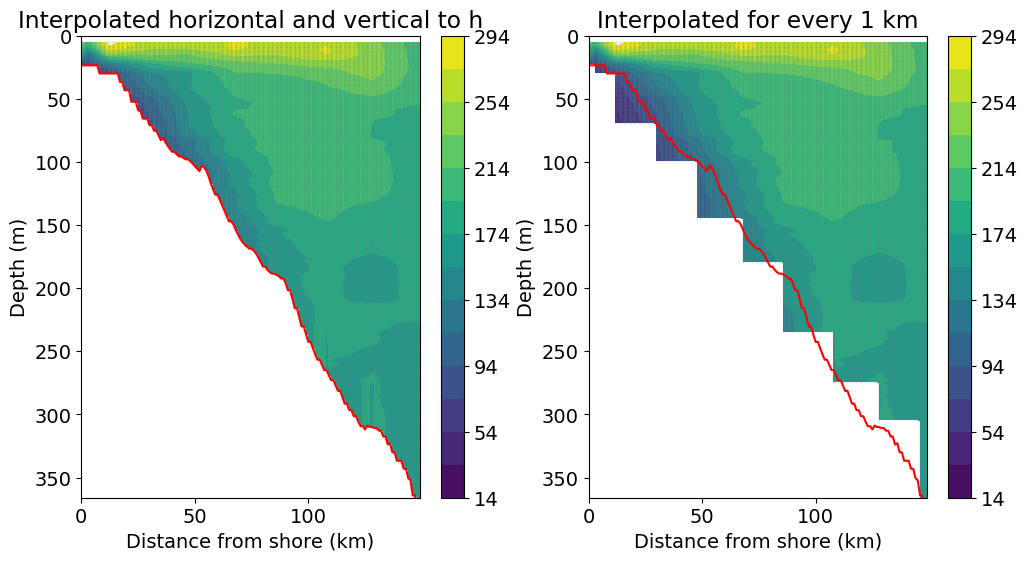

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(DO_transect_interpolated_final.dist2shore, DO_transect_interpolated_final.depth, DO_transect_interpolated_final.oxy.isel(month=0), levels=np.arange(14,302, 20))
plt.ylim(366,0)
plt.colorbar()
plt.xlabel('Distance from shore (km)')
plt.ylabel('Depth (m)')
plt.title('Interpolated horizontal and vertical to h')

plt.plot(np.arange(150), h_sel, 'r')

for stn in range(DO_transect_interpolated_final.dist2shore.size):
    if stn%2==0:
        ind = ~np.isnan(DO_transect_interpolated_final.oxy.isel(month=0, dist2shore=stn).values)
        x_ = ind*DO_transect_interpolated_final.dist2shore.values[stn]
        plt.scatter(x_[ind], DO_transect_interpolated_final.depth.values[ind], c='gray', s=1, alpha=0.1)


plt.subplot(1, 2, 2)
plt.contourf(DO_transect_interpolated.dist2shore, DO_transect_interpolated.depth, DO_transect_interpolated.oxy.isel(month=0), levels=np.arange(14,302, 20))
plt.ylim(366,0)
plt.colorbar()
plt.xlabel('Distance from shore (km)')
plt.ylabel('Depth (m)')
plt.title('Interpolated for every 1 km')

plt.plot(np.arange(150), h_sel, 'r')

for stn in range(DO_transect_interpolated.dist2shore.size):
    if stn%2==0:
        ind = ~np.isnan(DO_transect_interpolated.oxy.isel(month=0, dist2shore=stn).values)
        x_ = ind*DO_transect_interpolated.dist2shore.values[stn]
        plt.scatter(x_[ind], DO_transect_interpolated.depth.values[ind], c='gray', s=1, alpha=0.1)

## New DO metrics for SHBML

Total area

In [50]:
dist

array([  0.        ,   2.85243572,  12.06478071,  29.99226413,
        47.96327518,  67.7021284 ,  85.99086158, 108.29039036,
       128.27193828, 145.97077783])

In [51]:
arr_d = ds.depth.values

In [53]:
# total area on shelf, m^2
total_area = 0
for stn in range(9):
    d = ds.isel(station=stn, month=0)
    depth_sel = arr_d[~np.isnan(d.oxy.values)]
    
    total_area += (depth_sel[-1] - depth_sel[0]) * (dist[stn+1] - dist[stn]) * 1000
total_area

24951714.120861784

In [54]:
# which station is 100m isobath?  ---> 3

for stn in range(9):
    d = ds.isel(station=stn, month=0)
    depth_sel = arr_d[~np.isnan(d.oxy.values)]
    
    print(stn, depth_sel[-1])


0 23
1 30
2 70
3 100
4 145
5 180
6 235
7 275
8 305


In [55]:
# total area inshore of 100m isobath
total_area_100m = 0
for stn in range(5):
    
    d = ds.isel(station=stn, month=0)
    depth_sel = arr_d[~np.isnan(d.oxy.values)]
    print(stn, depth_sel[-1])
    
    total_area_100m += (depth_sel[-1] - depth_sel[0]) * (dist[stn+1] - dist[stn]) * 1000

0 23
1 30
2 70
3 100
4 145


In [56]:
total_area_100m, total_area_100m / total_area

(5917624.390421074, 0.23716304065352486)

/tmp/ipykernel_3138834/984852963.py:42: UserWarning: No contour levels were found within the data range.
  contour_line = plt.contour(x, y, data, levels=[60], colors='black', linestyles='dashed', linewidths=2)


Month 9 Area (m^2) with values less than 60: 0.0
Month 10 Area (m^2) with values less than 60: 0.0
Month 11 Area (m^2) with values less than 60: 0.0
Month 12 Area (m^2) with values less than 60: 0.0
Month 1 Area (m^2) with values less than 60: 0.0
Month 2 Area (m^2) with values less than 60: 1211.571447898109
Month 3 Area (m^2) with values less than 60: 147542.5980497741
Month 4 Area (m^2) with values less than 60: 84802.96802884391
Month 5 Area (m^2) with values less than 60: 74644.45305619302
Month 6 Area (m^2) with values less than 60: 0.0
Month 7 Area (m^2) with values less than 60: 0.0
Month 8 Area (m^2) with values less than 60: 0.0


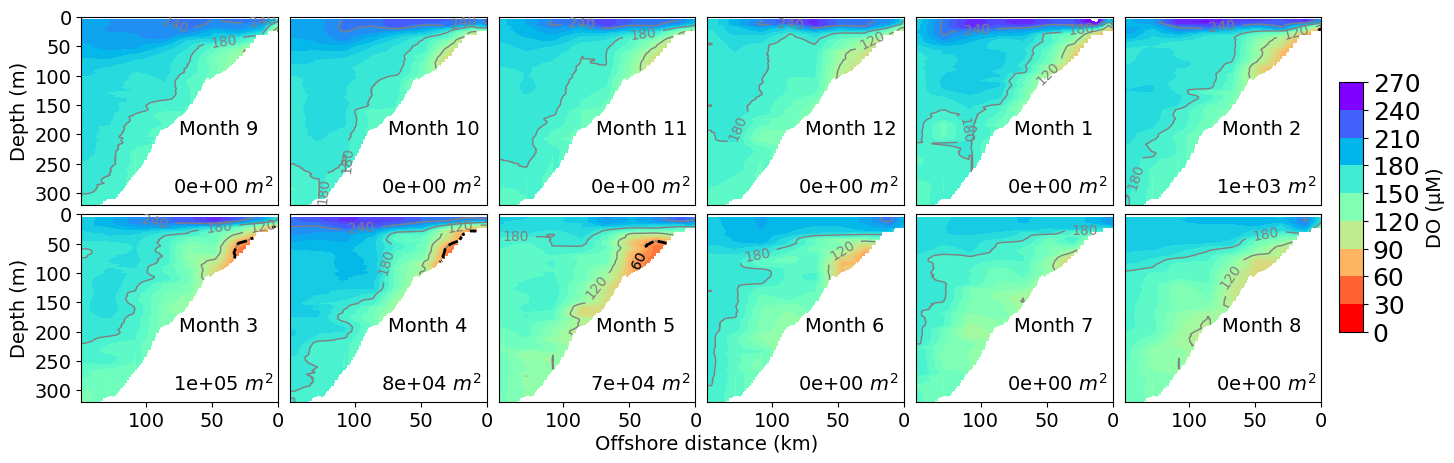

In [74]:
arr_area_hypoxia = []

plt.rcParams.update({'font.size': 14})

def add_colorbar(x0, y0, vmin, vmax, label, cmap_label='rainbow_r', levels=np.arange(0, 300, 30)):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar
    levels: discrete levels for the colorbar
    '''
    cax = fig.add_axes([x0, y0, 0.015, 0.5])  # [x0, y0, width, height]
    
    # Create a colormap and normalization based on the levels
    cmap = plt.get_cmap(cmap_label, len(levels) - 1)  # get discrete colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Create the ScalarMappable with the discrete colormap and norm
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for the colorbar

    # Create the colorbar
    cbar = fig.colorbar(sm, cax=cax, shrink=0.9, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(levels)  # Set the ticks to match the levels

order = [9,10,11,12,1,2,3,4,5,6,7,8]

fig = plt.figure(figsize=(16, 5))

for t in range(12):
    ax = fig.add_subplot(2, 6, t+1)
    
    data = DO_transect_interpolated_final.oxy.sel(month=order[t])
    x = DO_transect_interpolated_final.dist2shore.values
    y = DO_transect_interpolated_final.depth.values
    plt.contourf(x, y, data, levels=np.arange(0,300, 10), cmap='rainbow_r') # cmap=cmocean.cm.oxy
    contours = plt.contour(x, y, data, levels=np.arange(0,300, 60), colors='gray', linestyles='solid', linewidths=1) # cmap=cmocean.cm.oxy
    plt.clabel(contours, inline=True, fontsize=10, fmt='%1.0f')
    
    # hypoxia line
    contour_line = plt.contour(x, y, data, levels=[60], colors='black', linestyles='dashed', linewidths=2)
    plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.0f')
    
    # Calculate the area of regions with values less than 1
    area = 0
    for collection in contour_line.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            area += 0.5 * np.abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) - np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))

    # print(f"Month {order[t]} Area (m^2) with values less than 60:", area*1000)
    # arr_area_hypoxia.append(area*1000)
    # ax.text(70, 300,  f"{area*1000/total_area*100:.2f} %")
    # plt.text(70, 200,  f"Month {order[t]}", fontsize=14)
    
    print(f"Month {order[t]} Area (m^2) with values less than 60:", area*1000)
    arr_area_hypoxia.append(area*1000)
    ax.text(80, 300,  f"{area*1000:.0e} $m^2$")
    plt.text(75, 200,  f"Month {order[t]}", fontsize=14)
            
    ax.set_ylim(320,0)
    ax.set_yticks([])
    if t in [0,6]:
        ax.set_yticks(np.arange(300, -40, -50))
        ax.set_ylabel('Depth (m)')
    if t >= 6:
        ax.set_xticks(np.arange(0, 150, 50))
        #ax.set_xlabel('Offshore distance (km)')
    if t < 6:
        ax.set_xticks([])

    #plt.title(order[t])
    plt.gca().invert_xaxis()

ax.text(550, 400, 'Offshore distance (km)')

add_colorbar(0.911, 0.25, 0, 300, 'DO (µM)')
plt.subplots_adjust(wspace=0.06, hspace=0.05)

#fig.savefig(f'./SHBMLclimatology_O2_new.png', bbox_inches='tight', dpi=200)

In [75]:
# total area on shelf, m^2

arr_d = DO_transect_interpolated_final.depth.values
dist = DO_transect_interpolated_final.dist2shore.values

total_area = 0
for stn in range(len(dist)-1):
    
    d = DO_transect_interpolated_final.isel(dist2shore=stn, month=0)
    depth_sel = arr_d[~np.isnan(d.oxy.values)]
    
    total_area += (depth_sel[-1] - depth_sel[0]) * (dist[stn+1] - dist[stn]) * 1000
total_area

25189000

In [77]:
arr_area_hypoxia

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1211.571447898109,
 147542.5980497741,
 84802.96802884391,
 74644.45305619302,
 0.0,
 0.0,
 0.0]

# Figure S2

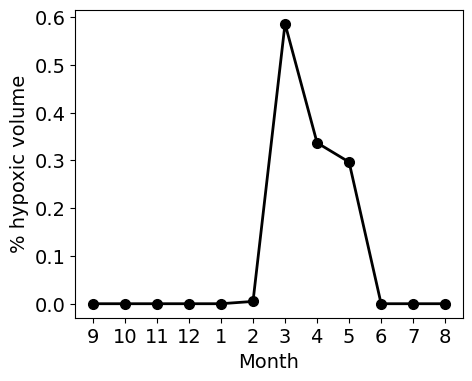

In [76]:
# Example data
fig = plt.figure(figsize=(5,4))
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Plot the data
plt.plot(np.arange(0,12), arr_area_hypoxia/total_area*100, marker='o', linewidth=2, color='k', markersize=7, label='Whole shelf')

plt.xlabel('Month')
plt.ylabel('% hypoxic volume')
plt.xticks(np.arange(0, 12), order);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.legend(fontsize=12)

#fig.savefig(f'./SHBMLclimatology_hypoxicArea_new.png', bbox_inches='tight', dpi=200)##
#fig.savefig(f'./GRL_figures/GRL_figure_S2.png', bbox_inches='tight', dpi=200)##

# Mooring DO

In [78]:
#load files
#model output
ns_mdl10m = pd.read_pickle('/d1/annette/Research/python/Manuscript/nearshore_10mextractionsfrom1kmmdl.pkl')
ns_mdl18m = pd.read_pickle('/d1/annette/Research/python/Manuscript/nearshore_18mextractions_ts_from1kmmdl.pkl')
ns_mdlwsc = pd.read_pickle('/d1/annette/Research/python/Manuscript/nearshore_wsc_from1kmmdl.pkl')
#20m mooring
ns_mooring = pd.read_pickle('/d1/annette/Research/python/Thesis/pickle_datafiles/WQM20m_daily.pkl') 
#SHBML data
#SHBML oxygen dataset 
SHBML = pd.read_pickle('/d1/annette/Research/python/Thesis/pickle_datafiles/SHBML_oxygen.pkl')
#pull station 1 @ 20m 
SHBML1 = SHBML[(SHBML['Station ID'] == '1')]
SHBML1_20m = SHBML1[(SHBML1['Depth [m]'] == 20)]
#add a year and month column
date = pd.to_datetime(SHBML1_20m.index,format='%Y-%m-%d')
month = pd.DatetimeIndex(date).month
year = pd.DatetimeIndex(date).year
SHBML1_20m['year'] = year
SHBML1_20m['month'] = month #returns an warning banner... I have been ignoring it. 
#sort for just the model run time period
ns_SHBML0812= SHBML1_20m[(SHBML1_20m['year']<=2012) & (SHBML1_20m['year']>=2008)] 

/tmp/ipykernel_3138834/3835853882.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHBML1_20m['year'] = year
/tmp/ipykernel_3138834/3835853882.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHBML1_20m['month'] = month #returns an warning banner... I have been ignoring it.


In [79]:
#weekly rolling averages of vars of interest
ns_Bakun_weekly = ns_mdl10m['Bakun'].rolling(7).mean()
ns_vv_weekly = ns_mdl10m['Vertical Velocity'].rolling(7).mean()
ns_vstress_weekly = ns_mdl10m['svstr'].rolling(7).mean()
ns_magwindstress_weekly = ns_mdl10m['Magnitude Wind Stress'].rolling(7).mean()
ns_vstresscurl_weekly = ns_mdlwsc['WSC'].rolling(7).mean()
ns_temp_18_weekly = ns_mdl18m['mdlTemp'].rolling(7).mean()
ns_mooringoxygen_weekly = ns_mooring['Oxygen'].rolling(7).mean()
ns_mooringtemp_weekly = ns_mooring['Temp'].rolling(7).mean()

In [80]:
#make a second dataframe of model output only: 
ns_wklymdlrun = pd.concat([ns_temp_18_weekly,ns_vstresscurl_weekly,ns_vv_weekly,ns_vstress_weekly,ns_magwindstress_weekly,ns_Bakun_weekly],axis=1)
ns_wklymdlrun = ns_wklymdlrun.dropna() #nans the first week because rolling average. 
#ns_wklymdlrun

#combine oxygen and metrics in time for scatters (weekly rolling avgs)
ns_paireddf = pd.concat([ns_vv_weekly,ns_Bakun_weekly,ns_vstress_weekly,ns_magwindstress_weekly,ns_vstresscurl_weekly,ns_temp_18_weekly,ns_mooringtemp_weekly,ns_mooringoxygen_weekly],axis=1) 
#remove nans 
ns_paireddf = ns_paireddf.dropna()

Read residence time

In [81]:
ds_2008 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2008_everyday/SHB_bottom_inshore100m_1polygon/year2008_efold_age.nc')
ds_2009 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2009_everyday/SHB_bottom_inshore100m_1polygon/year2009_efold_age.nc')
ds_2010 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2010_everyday/SHB_bottom_inshore100m_1polygon/year2010_efold_age.nc')
ds_2011 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2011_everyday/SHB_bottom_inshore100m_1polygon/year2011_efold_age.nc')
ds_2012 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/loop2012_everyday/SHB_bottom_inshore100m_1polygon/year2012_efold_age.nc')
whole_ds_1poly100m = xr.concat((ds_2008, ds_2009, ds_2010, ds_2011, ds_2012), dim='time')

ds_2008 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2008_everyday/SHB_bottom_inshore100m_1polygon_noMLD/year2008_efold_age.nc')
ds_2009 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2009_everyday/SHB_bottom_inshore100m_1polygon_noMLD/year2009_efold_age.nc')
ds_2010 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2010_everyday/SHB_bottom_inshore100m_1polygon_noMLD/year2010_efold_age.nc')
ds_2011 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/year2011_everyday/SHB_bottom_inshore100m_1polygon_noMLD/year2011_efold_age.nc')
ds_2012 = xr.open_dataset('/d1/mengyang/Benguela/Particle_tracking/tempdir/res_time_percent_efold/loop2012_everyday/SHB_bottom_inshore100m_1polygon_noMLD/year2012_efold_age.nc')
whole_ds_1poly100m_noMLD = xr.concat((ds_2008, ds_2009, ds_2010, ds_2011, ds_2012), dim='time')

Read mixed layer depth

In [82]:
N2_mld_all = np.load('/d1/mengyang/Benguela/Mixed_layer_depth/mld_5years_N2.npy')
# all years of mixed layer depth from croco metric
cro_mld2008 = np.load('/d1/mengyang/Benguela/Mixed_layer_depth/cro_mld2008.npy')
cro_mld2009 = np.load('/d1/mengyang/Benguela/Mixed_layer_depth/cro_mld2009.npy')
cro_mld2010 = np.load('/d1/mengyang/Benguela/Mixed_layer_depth/cro_mld2010.npy')
cro_mld2011 = np.load('/d1/mengyang/Benguela/Mixed_layer_depth/cro_mld2011.npy')
cro_mld2012 = np.load('/d1/mengyang/Benguela/Mixed_layer_depth/cro_mld2012.npy')
cro_mld_all = np.concatenate((cro_mld2008, cro_mld2009, cro_mld2010, cro_mld2011, cro_mld2012), axis=0)

In [83]:
whole_ds_1poly100m['MLD_N2'] = (('time', 'eta_rho', 'xi_rho'), N2_mld_all)
whole_ds_1poly100m['MLD_cro'] = (('time', 'eta_rho', 'xi_rho'), cro_mld_all)

In [84]:
da = xr.open_mfdataset('/d1/mengyang/Benguela/Particle_tracking/output_1km/avg_Y2012.nc')

tlong = da.lon_rho.values
tlat = da.lat_rho.values
mask = da.mask_rho.isel(time=0).values
inshore_mask = xr.where(da.isel(time=0).h <= 100, 1, 0)  # inshore of 100m
mask_sel = mask*inshore_mask

In [85]:
def get_monthly(whole_ds_var):
    '''return mean and std of a'''
    mean = whole_ds_var.groupby('time.month').mean(dim='time').isel(eta_rho=109, xi_rho=71)
    std = whole_ds_var.groupby('time.month').std(dim='time').isel(eta_rho=109, xi_rho=71)
    
    return mean, std

In [86]:
def reorder(mean):
    return np.concatenate((mean[-4:], mean[:-4]))

xticks = np.concatenate((np.arange(9,13), np.arange(1,9)))
string_numbers = [str(xt) for xt in xticks]
string_numbers

['9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8']

T_res

In [87]:
# mean and std of Tres, Tres_noMLD for inshore of 100m
mean_100m, std_100m = get_monthly(whole_ds_1poly100m.efold_time_int)
mean_noMLD_100m, std_noMLD_100m = get_monthly(whole_ds_1poly100m_noMLD.efold_time_int)
mean_diff_100m, std_diff_100m = get_monthly((whole_ds_1poly100m_noMLD - whole_ds_1poly100m).efold_time_int)

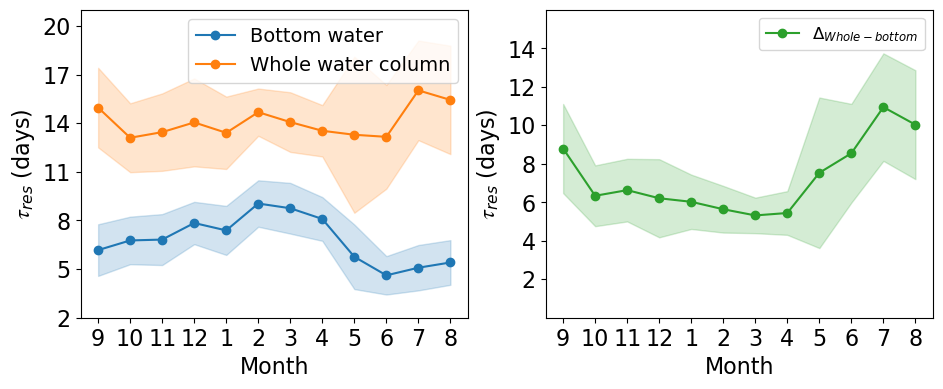

In [88]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,2, figsize=(11, 4))

axes[0].plot(mean_100m['month'], reorder(mean_100m), marker='o', label='Bottom water', color='C0')
axes[0].fill_between(mean_100m['month'], reorder(mean_100m) - reorder(std_100m), reorder(mean_100m) + reorder(std_100m), alpha=0.2, color='C0')
axes[0].plot(mean_noMLD_100m['month'], reorder(mean_noMLD_100m), marker='o', label='Whole water column', color='C1')
axes[0].fill_between(mean_noMLD_100m['month'], reorder(mean_noMLD_100m) - reorder(std_noMLD_100m), reorder(mean_noMLD_100m) + reorder(std_noMLD_100m), alpha=0.2, color='C1')

axes[1].plot(mean_diff_100m['month'], reorder(mean_diff_100m), marker='o', label='$\Delta_{Whole-bottom}$', color='C2')
axes[1].fill_between(mean_diff_100m['month'], reorder(mean_diff_100m) - reorder(std_diff_100m), reorder(mean_diff_100m) + reorder(std_diff_100m), alpha=0.2, color='C2')

axes[0].set_xlabel('Month')
axes[1].set_xlabel('Month')
axes[0].set_ylabel('$𝜏_{res}$ (days)')
axes[1].set_ylabel('$𝜏_{res}$ (days)')

axes[0].set_ylim(2,21)
axes[1].set_ylim(0,16)
axes[0].set_xticks(np.arange(1,13), string_numbers)
axes[1].set_xticks(np.arange(1,13),  string_numbers);
axes[0].set_yticks(np.arange(2,21,3));
axes[1].set_yticks(np.arange(2,16,2));

axes[0].legend(fontsize=14)
axes[1].legend(fontsize=12)


#plt.savefig('./figures/MLD_influence_Tres_100m.png',bbox_inches='tight',dpi=200)

APG, stratification

In [89]:
ds_stra = xr.open_dataset(f'/d1/mengyang/Benguela/Mixed_layer_depth/Stratification_results/ds_stratification.nc')

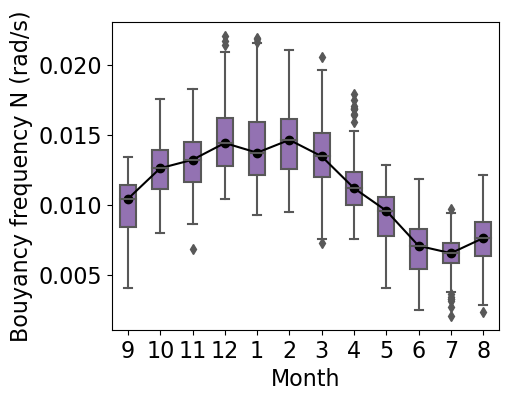

In [92]:
plt.rcParams.update({'font.size': 16})
var_name = 'N2_int'
var_data = ds_stra[var_name]
df = var_data.to_dataframe()
df['Month'] = df.index.month

# reorder months
df_copy = df.copy()
for i in range(12):
    df_copy.loc[df_copy['Month'] == xticks[i], 'Month'] = str(i+1)
df_copy['Month'] = df_copy['Month'].astype(int)

# Create a box-and-whisker plot using seaborn
fig = plt.figure(figsize=(5, 4))
ax = sns.boxplot(x='Month', y=var_name, data=df_copy, width=0.5, color='C4')

# plot medians
monthly_median = var_data.groupby('time.month').median('time')
plt.plot(np.arange(0,12), reorder(monthly_median), marker='o', color='black')

N_monthly_median = monthly_median

# Customize the plot labels and title
plt.xlabel('Month')
plt.ylabel('Bouyancy frequency N (rad/s)')
plt.xticks(np.arange(12), string_numbers);
#plt.yticks(np.arange(0,18,2));
#plt.title(f'Box-and-Whisker Plot for {var_name} by Month')
#plt.ylim(1,12)
#fig.savefig('climatology_stratification.png',bbox_inches='tight',dpi=200)

In [93]:
ds_slope = xr.open_dataset(f'/d1/mengyang/Benguela/APG_Hypoxia_metric/ds_slope_APG_3km_domain.nc')
ds_slope_bay = xr.open_dataset(f'/d1/mengyang/Benguela/APG_Hypoxia_metric/ds_slope_APG_3km_domain_bay.nc')

ds_slope_adjusted_APG = xr.open_dataset(f'/d1/mengyang/Benguela/APG_Hypoxia_metric/ds_slope_APG_3km_domain_adjusted_closer2shore.nc')
ds_slope_bay_adjusted = xr.open_dataset(f'/d1/mengyang/Benguela/APG_Hypoxia_metric/ds_slope_APG_3km_domain_bay_adjusted_closer2shore.nc')

In [94]:
ds_slope_adjusted = xr.open_dataset(f'/d1/mengyang/Benguela/APG_Hypoxia_metric/ds_slope_APG_3km_domain_adjusted_horizontal.nc')

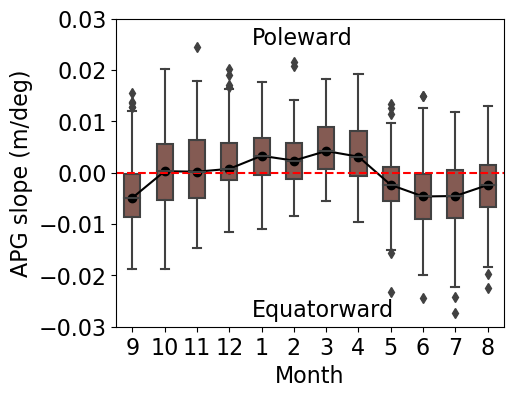

In [95]:
plt.rcParams.update({'font.size': 16})
var_name = 'slope'
var_data = ds_slope_adjusted_APG[var_name]
df = var_data.to_dataframe()
df['Month'] = df.index.month

# reorder months
df_copy = df.copy()
for i in range(12):
    df_copy.loc[df_copy['Month'] == xticks[i], 'Month'] = str(i+1)
df_copy['Month'] = df_copy['Month'].astype(int)

# Create a box-and-whisker plot using seaborn
fig = plt.figure(figsize=(5, 4))
ax = sns.boxplot(x='Month', y=var_name, data=df_copy, width=0.5, color='C5')

# plot medians
monthly_median = var_data.groupby('time.month').median('time')
plt.plot(np.arange(0,12), reorder(monthly_median), marker='o', color='black')

plt.plot([-0.5,11.5],[0,0], 'r--')
plt.text(3.7, 0.025, 'Poleward')
plt.text(3.7, -0.028, 'Equatorward')
plt.ylim(-0.03, 0.03)

# Customize the plot labels and title
plt.xlabel('Month')
plt.ylabel('APG slope (m/deg)')
plt.xticks(np.arange(12), string_numbers);
#plt.yticks(np.arange(0,18,2));
#plt.title(f'Box-and-Whisker Plot for {var_name} by Month')
#plt.ylim(1,12)
#fig.savefig('climatology_APGslope_adjusted_closer2shore.png',bbox_inches='tight',dpi=200)

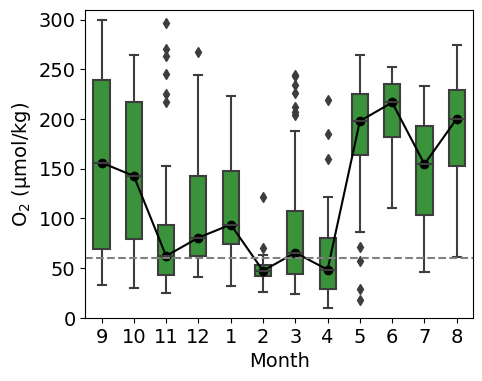

In [121]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)

def plot_DO_20m(ax):
    var_name = 'Oxygen'
    ns_mooring['Month'] = ns_mooring.index.month

    # reorder months
    ns_mooring_copy = ns_mooring.copy()
    for i in range(12):
        ns_mooring_copy.loc[ns_mooring_copy['Month'] == xticks[i], 'Month'] = str(i+1)
    ns_mooring_copy['Month'] = ns_mooring_copy['Month'].astype(int)


    # Create a box-and-whisker plot using seaborn
    sns.boxplot(ax=ax, x='Month', y=var_name, data=ns_mooring_copy, width=0.5, color='C2')

    # plot medians
    monthly_median = ns_mooring_copy.groupby('Month')[var_name].median().reset_index()
    ax.plot(np.arange(0,12), (monthly_median[var_name]), marker='o', color='black')

    ax.axhline(y=60, linestyle='--',color='gray')
    ax.set_xticks(np.arange(12), string_numbers)
    ax.set_xlabel('Month')
    ax.set_ylabel('O$_2$ (µmol/kg)')
    ax.set_ylim(0, 310)
    ax.set_yticks(np.arange(0,310,50));

    #plt.savefig('climatology_DO_20m.png',bbox_inches='tight',dpi=200)
plot_DO_20m(ax)

/tmp/ipykernel_3138834/1082936460.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 4}, ignore_index=True)
/tmp/ipykernel_3138834/1082936460.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 5}, ignore_index=True)


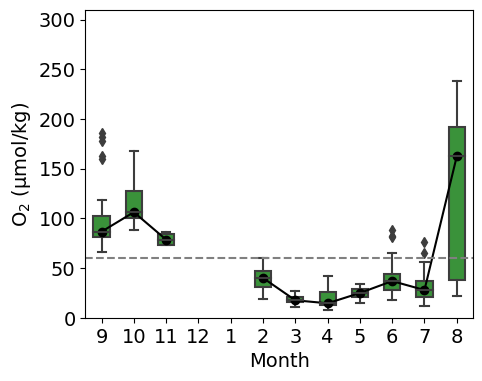

In [123]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)

def plot_DO_70m(ax):

    mooring_70m = pd.read_pickle('/d1/annette/Research/python/Thesis/pickle_datafiles/WQM70m_daily.pkl') 
    var_name = 'Oxygen'
    mooring_70m['Month'] = mooring_70m.index.month

    # reorder months
    mooring_70m_copy = mooring_70m.copy()
    xticks_ = np.array([ 9, 10, 11, 2,  3,  4,  5,  6,  7,  8])
    string_numbers_ = [str(xt) for xt in xticks_]
    for i in range(10):
        if i<=2:
            mooring_70m_copy.loc[mooring_70m_copy['Month'] == xticks_[i], 'Month'] = str(i+1)
        else:
            mooring_70m_copy.loc[mooring_70m_copy['Month'] == xticks_[i], 'Month'] = str(i+3)
    mooring_70m_copy['Month'] = mooring_70m_copy['Month'].astype(int)

    mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 4}, ignore_index=True)
    mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 5}, ignore_index=True)

    # Create a box-and-whisker plot using seaborn

    sns.boxplot(ax=ax, x='Month', y=var_name, data=mooring_70m_copy, width=0.5, color='C2')

    # plot medians
    monthly_median = mooring_70m_copy.groupby('Month')[var_name].median().reset_index()
    ax.plot(np.arange(12), (monthly_median[var_name]), marker='o', color='black')

    ax.axhline(y=60, linestyle='--',color='gray')
    ax.set_xticks(np.arange(12), string_numbers)
    ax.set_xlabel('Month')
    ax.set_ylabel('O$_2$ (µmol/kg)');
    ax.set_ylim(0, 310)
    ax.set_yticks(np.arange(0,310,50));

plot_DO_70m(ax)

# Figure 1

In [134]:
10%6, 10//6

(4, 1)

/tmp/ipykernel_3138834/1082936460.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 4}, ignore_index=True)
/tmp/ipykernel_3138834/1082936460.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 5}, ignore_index=True)
/tmp/ipykernel_3138834/3178423940.py:82: UserWarning: No contour levels were found within the data range.
  contour_line = plt.contour(x, y, data, levels=[60], colors='black', linestyles='dashed', linewidths=2)


Month 9 Area (m^2) with values less than 60: 0.0
Month 10 Area (m^2) with values less than 60: 0.0
Month 11 Area (m^2) with values less than 60: 0.0
Month 12 Area (m^2) with values less than 60: 0.0
Month 1 Area (m^2) with values less than 60: 0.0
Month 2 Area (m^2) with values less than 60: 1211.571447898109
Month 3 Area (m^2) with values less than 60: 147542.5980497741
Month 4 Area (m^2) with values less than 60: 84802.96802884391
Month 5 Area (m^2) with values less than 60: 407069.00627556024
Month 6 Area (m^2) with values less than 60: 0.0
Month 7 Area (m^2) with values less than 60: 0.0
Month 8 Area (m^2) with values less than 60: 0.0


/tmp/ipykernel_3138834/3178423940.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3138834/3178423940.py:116: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/d1/mengyang/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


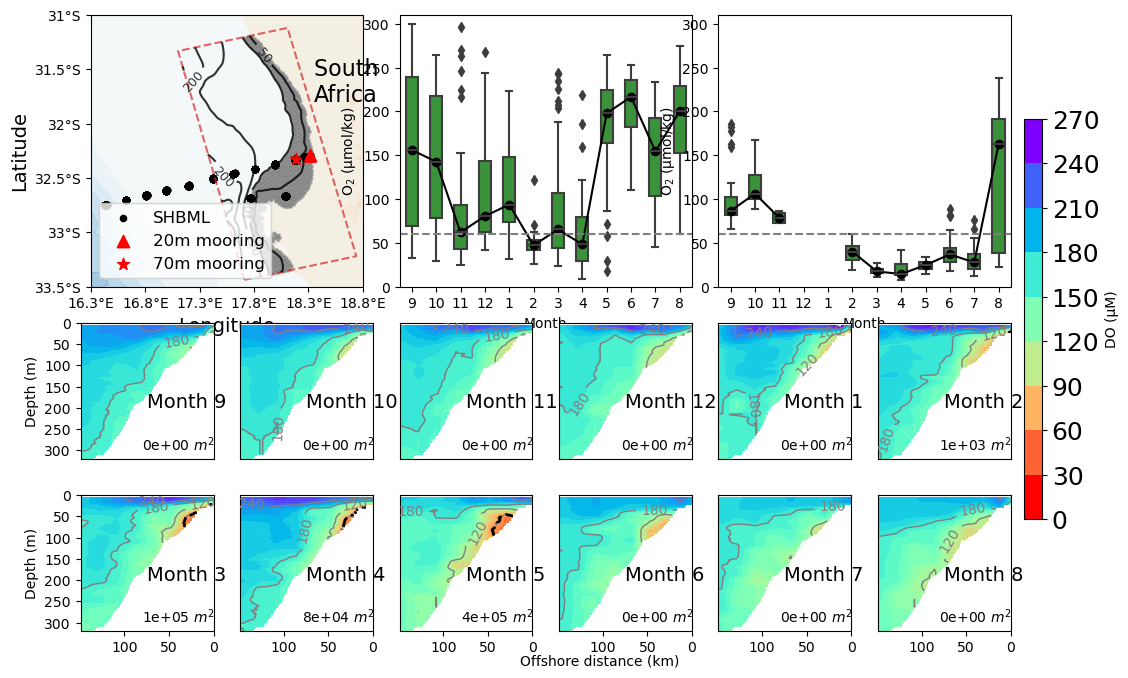

In [145]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 10})

# Create the figure
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = gridspec.GridSpec(3, 6, height_ratios=[2, 1, 1])

#gs.update( wspace=0.2, hspace=0.3)

# First row: 3 columns (ax1, ax2, ax3)
ax1 = plt.subplot(gs[0, 0:2], projection=ccrs.PlateCarree())  # Span first 2 columns for plot 1
ax2 = plt.subplot(gs[0, 2:4])  # Span middle 2 columns for plot 2
ax3 = plt.subplot(gs[0, 4:6])  # Span last 2 columns for plot 3



# # Second row: 6 columns
# ax4 = plt.subplot(gs[1, 0])  # Column 1
# ax5 = plt.subplot(gs[1, 1])  # Column 2
# ax6 = plt.subplot(gs[1, 2])  # Column 3
# ax7 = plt.subplot(gs[1, 3])  # Column 4
# ax8 = plt.subplot(gs[1, 4])  # Column 5
# ax9 = plt.subplot(gs[1, 5])  # Column 6

# gs.update(wspace=0.1, hspace=0.15)

# # Third row: 6 columns
# ax10 = plt.subplot(gs[2, 0])  # Column 1
# ax11 = plt.subplot(gs[2, 1])  # Column 2
# ax12 = plt.subplot(gs[2, 2])  # Column 3
# ax13 = plt.subplot(gs[2, 3])  # Column 4
# ax14 = plt.subplot(gs[2, 4])  # Column 5
# ax15 = plt.subplot(gs[2, 5])  # Column 6

plot_map(ax1)
plot_DO_20m(ax2)
plot_DO_70m(ax3)

#plt.subplots_adjust(wspace=0.06, hspace=0.05)


arr_area_hypoxia = []
def add_colorbar(x0, y0, vmin, vmax, label, cmap_label='rainbow_r', levels=np.arange(0, 300, 30)):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar
    levels: discrete levels for the colorbar
    '''
    cax = fig.add_axes([x0, y0, 0.015, 0.5])  # [x0, y0, width, height]
    
    # Create a colormap and normalization based on the levels
    cmap = plt.get_cmap(cmap_label, len(levels) - 1)  # get discrete colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Create the ScalarMappable with the discrete colormap and norm
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for the colorbar

    # Create the colorbar
    cbar = fig.colorbar(sm, cax=cax, shrink=0.9, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(levels)  # Set the ticks to match the levels

order = [9,10,11,12,1,2,3,4,5,6,7,8]

for t in range(12):
    #ax = fig.add_subplot(2, 6, t+1)
    ax = plt.subplot(gs[t//6+1, t%6]) 
    #gs.update( wspace=0.1, hspace=0.1)
    
    data = DO_transect_interpolated_final.oxy.sel(month=order[t])
    x = DO_transect_interpolated_final.dist2shore.values
    y = DO_transect_interpolated_final.depth.values
    plt.contourf(x, y, data, levels=np.arange(0,300, 10), cmap='rainbow_r') # cmap=cmocean.cm.oxy
    contours = plt.contour(x, y, data, levels=np.arange(0,300, 60), colors='gray', linestyles='solid', linewidths=1) # cmap=cmocean.cm.oxy
    plt.clabel(contours, inline=True, fontsize=10, fmt='%1.0f')
    
    # hypoxia line
    contour_line = plt.contour(x, y, data, levels=[60], colors='black', linestyles='dashed', linewidths=2)
    plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.0f')
    
    # Calculate the area of regions with values less than 1
    area = 0
    for collection in contour_line.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            area += 0.5 * np.abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) - np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))
    
    print(f"Month {order[t]} Area (m^2) with values less than 60:", area*1000)
    arr_area_hypoxia.append(area*1000)
    ax.text(80, 300,  f"{area*1000:.0e} $m^2$")
    plt.text(75, 200,  f"Month {order[t]}", fontsize=14)
            
    ax.set_ylim(320,0)
    ax.set_yticks([])
    if t in [0,6]:
        ax.set_yticks(np.arange(300, -40, -50))
        ax.set_ylabel('Depth (m)')
    if t >= 6:
        ax.set_xticks(np.arange(0, 150, 50))
        #ax.set_xlabel('Offshore distance (km)')
    if t < 6:
        ax.set_xticks([])

    #plt.title(order[t])
    plt.gca().invert_xaxis()

ax.text(550, 400, 'Offshore distance (km)')

add_colorbar(0.911, 0.25, 0, 300, 'DO (µM)')
#plt.subplots_adjust(wspace=0.06, hspace=0.05)
plt.tight_layout()

#fig.savefig(f'./SHBMLclimatology_O2_new.png', bbox_inches='tight', dpi=200)

## Figure 1 hal

/tmp/ipykernel_3138834/1082936460.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 4}, ignore_index=True)
/tmp/ipykernel_3138834/1082936460.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mooring_70m_copy = mooring_70m_copy.append({var_name: np.nan, 'Month': 5}, ignore_index=True)
/tmp/ipykernel_3138834/1104550998.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.26, hspace=0.05)


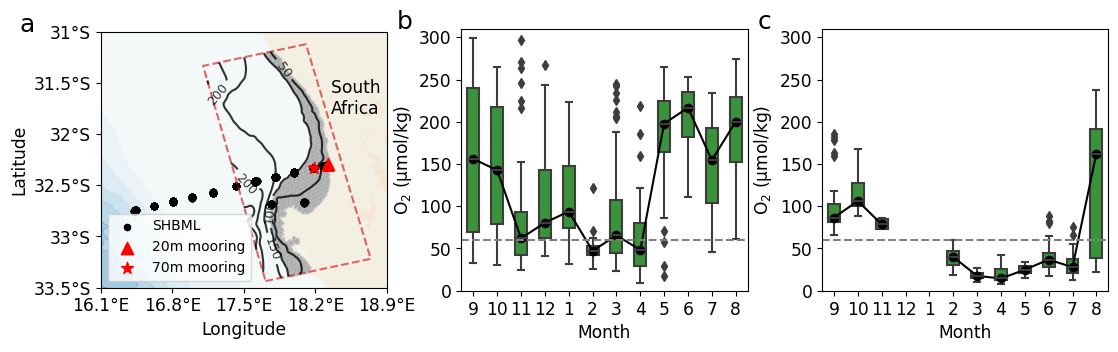

In [244]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 12.3})

# Create the figure
fig = plt.figure(figsize=(13, 3.4), constrained_layout=True)
gs = gridspec.GridSpec(1, 3)

# First row: 3 columns (ax1, ax2, ax3)
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())  # Span first 2 columns for plot 1
ax2 = plt.subplot(gs[0, 1])  # Span middle 2 columns for plot 2
ax3 = plt.subplot(gs[0, 2])  # Span last 2 columns for plot 3

plot_map(ax1)
plot_DO_20m(ax2)
plot_DO_70m(ax3)

plt.subplots_adjust(wspace=0.26, hspace=0.05)

ax1.text(15.3, -31, 'a', fontsize=18)
ax2.text(-3.2, 310, 'b', fontsize=18)
ax3.text(-3.2, 310, 'c', fontsize=18)

fig.savefig(f'./GRL_figures/GRL_figure1_half.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_3138834/2200588688.py:42: UserWarning: No contour levels were found within the data range.
  contour_line = plt.contour(x, y, data, levels=[60], colors='black', linestyles='dashed', linewidths=2)


Month 9 Area (m^2) with values less than 60: 0.0
Month 10 Area (m^2) with values less than 60: 0.0
Month 11 Area (m^2) with values less than 60: 0.0
Month 12 Area (m^2) with values less than 60: 0.0
Month 1 Area (m^2) with values less than 60: 0.0
Month 2 Area (m^2) with values less than 60: 1211.571447898109
Month 3 Area (m^2) with values less than 60: 147542.5980497741
Month 4 Area (m^2) with values less than 60: 84802.96802884391
Month 5 Area (m^2) with values less than 60: 33911.74639459496
Month 6 Area (m^2) with values less than 60: 0.0
Month 7 Area (m^2) with values less than 60: 0.0
Month 8 Area (m^2) with values less than 60: 0.0


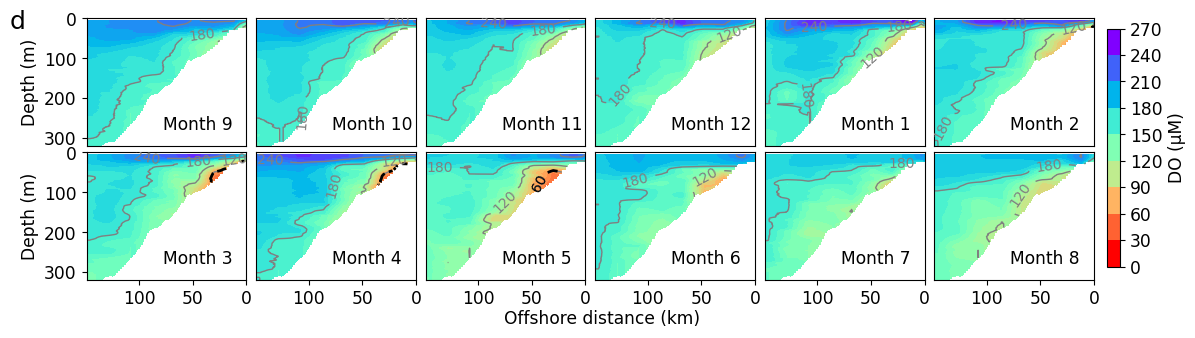

In [249]:
arr_area_hypoxia = []

plt.rcParams.update({'font.size': 12.3})

def add_colorbar(x0, y0, vmin, vmax, label, cmap_label='rainbow_r', levels=np.arange(0, 300, 30)):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar
    levels: discrete levels for the colorbar
    '''
    cax = fig.add_axes([x0, y0, 0.01, 0.7])  # [x0, y0, width, height]
    
    # Create a colormap and normalization based on the levels
    cmap = plt.get_cmap(cmap_label, len(levels) - 1)  # get discrete colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Create the ScalarMappable with the discrete colormap and norm
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for the colorbar

    # Create the colorbar
    cbar = fig.colorbar(sm, cax=cax, shrink=0.9, label=label, orientation='vertical')
    #cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(levels)  # Set the ticks to match the levels

order = [9,10,11,12,1,2,3,4,5,6,7,8]

fig = plt.figure(figsize=(13, 3.4))

for t in range(12):
    ax = fig.add_subplot(2, 6, t+1)
    
    data = DO_transect_interpolated_final.oxy.sel(month=order[t])
    x = DO_transect_interpolated_final.dist2shore.values
    y = DO_transect_interpolated_final.depth.values
    plt.contourf(x, y, data, levels=np.arange(0,300, 10), cmap='rainbow_r') # cmap=cmocean.cm.oxy
    contours = plt.contour(x, y, data, levels=np.arange(0,300, 60), colors='gray', linestyles='solid', linewidths=1) # cmap=cmocean.cm.oxy
    plt.clabel(contours, inline=True, fontsize=10, fmt='%1.0f')
    
    # hypoxia line
    contour_line = plt.contour(x, y, data, levels=[60], colors='black', linestyles='dashed', linewidths=2)
    plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.0f')
    
    # Calculate the area of regions with values less than 1
    area = 0
    for collection in contour_line.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            area += 0.5 * np.abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) - np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))

    # print(f"Month {order[t]} Area (m^2) with values less than 60:", area*1000)
    # arr_area_hypoxia.append(area*1000)
    # ax.text(70, 300,  f"{area*1000/total_area*100:.2f} %")
    # plt.text(70, 200,  f"Month {order[t]}", fontsize=14)
    
    print(f"Month {order[t]} Area (m^2) with values less than 60:", area*1000)
    arr_area_hypoxia.append(area*1000)
    #ax.text(84, 300,  f"{area*1000:.0e} $m^2$")
    plt.text(78, 280,  f"Month {order[t]}")
            
    ax.set_ylim(320,0)
    ax.set_yticks([])
    if t in [0,6]:
        ax.set_yticks(np.arange(300, -40, -100))
        ax.set_ylabel('Depth (m)')
    if t >= 6:
        ax.set_xticks(np.arange(0, 150, 50))
        #ax.set_xlabel('Offshore distance (km)')
    if t < 6:
        ax.set_xticks([])

    #plt.title(order[t])
    plt.gca().invert_xaxis()

ax.text(550, 430, 'Offshore distance (km)')
ax.text(1010, -310, 'd', fontsize=18)

add_colorbar(0.91, 0.15, 0, 300, 'DO (µM)')
plt.subplots_adjust(wspace=0.06, hspace=0.05)

#fig.savefig(f'./GRL_figures/GRL_figure1_half2.png', bbox_inches='tight', dpi=200)

# Figure 3

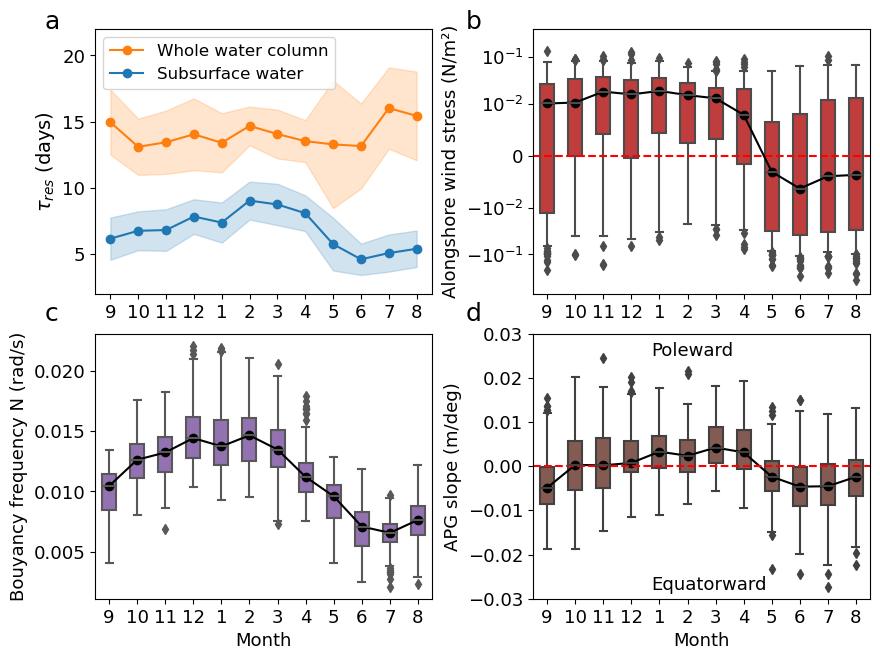

In [340]:
plt.rcParams.update({'font.size': 13})
FONTSIZE = 15

fig = plt.figure(figsize=(10,7.4))
ax0 = fig.add_subplot(2,2, 1)
ax1 = fig.add_subplot(2,2, 2)
ax2 = fig.add_subplot(2,2, 3)
ax3 = fig.add_subplot(2,2, 4)
plt.subplots_adjust(wspace=0.3, hspace=0.15)

####### T_res
ax = ax0

ax.plot(mean_noMLD_100m['month']-1, reorder(mean_noMLD_100m), marker='o', label='Whole water column', color='C1')
ax.fill_between(mean_noMLD_100m['month']-1, reorder(mean_noMLD_100m) - reorder(std_noMLD_100m), reorder(mean_noMLD_100m) + reorder(std_noMLD_100m), alpha=0.2, color='C1')
ax.plot(mean_100m['month']-1, reorder(mean_100m), marker='o', label='Subsurface water', color='C0')
ax.fill_between(mean_100m['month']-1, reorder(mean_100m) - reorder(std_100m), reorder(mean_100m) + reorder(std_100m), alpha=0.2, color='C0')

ax.set_xticks(np.arange(12), string_numbers);
ax.set_xlabel('')
ax.set_ylabel(r"$\tau_{res}$ (days)", fontsize=14)
ax.set_ylim(2,22)

ax.legend(loc='upper left', fontsize=12)


######### wind stress
ax = ax1
var_name = 'svstr'
ns_mdl10m['Month'] = ns_mdl10m.index.month
# reorder months
ns_mdl10m_copy = ns_mdl10m.copy()
for i in range(12):
    ns_mdl10m_copy.loc[ns_mdl10m_copy['Month'] == xticks[i], 'Month'] = str(i+1)
ns_mdl10m_copy['Month'] = ns_mdl10m_copy['Month'].astype(int)

# Create a box-and-whisker plot using seaborn
sns.boxplot(ax=ax, x='Month', y=var_name, data=ns_mdl10m_copy, width=0.5, color='C3')
ax.axhline(y=0, color='r', linestyle='--', label='y=0')

# plot medians
monthly_median = ns_mdl10m_copy.groupby('Month')[var_name].median().reset_index()
ax.plot(np.arange(0,12), monthly_median[var_name], marker='o', color='black')
ax.set_ylabel("Alongshore wind stress (N/m\u00b2)")
ax.set_xlabel("")
ax.set_xticks(np.arange(12), string_numbers);
ax.set_yscale('symlog', linthresh=0.01)
ax.set_ylim(-0.7, 0.4)

tau_monthly_median = monthly_median


######## stratification
ax= ax2
var_name = 'N2_int'
var_data = ds_stra[var_name]
df = var_data.to_dataframe()
df['Month'] = df.index.month
# reorder months
df_copy = df.copy()
for i in range(12):
    df_copy.loc[df_copy['Month'] == xticks[i], 'Month'] = str(i+1)
df_copy['Month'] = df_copy['Month'].astype(int)

sns.boxplot(ax=ax, x='Month', y=var_name, data=df_copy, width=0.5, color='C4')

# plot medians
monthly_median = var_data.groupby('time.month').median('time')
ax.plot(np.arange(0,12), reorder(monthly_median), marker='o', color='black')

N_monthly_median = monthly_median
ax.set_xticks(np.arange(12), string_numbers);
ax.set_xlabel('Month')
ax.set_ylabel("Bouyancy frequency N (rad/s)")


######## APG
ax = ax3
var_name = 'slope'
var_data = ds_slope_adjusted_APG[var_name]
df = var_data.to_dataframe()
df['Month'] = df.index.month
# reorder months
df_copy = df.copy()
for i in range(12):
    df_copy.loc[df_copy['Month'] == xticks[i], 'Month'] = str(i+1)
df_copy['Month'] = df_copy['Month'].astype(int)

sns.boxplot(ax=ax, x='Month', y=var_name, data=df_copy, width=0.5, color='C5')

# plot median
monthly_median = var_data.groupby('time.month').median('time')
ax.plot(np.arange(0,12), reorder(monthly_median), marker='o', color='black')
ax.plot([-0.5,11.5],[0,0], 'r--')
ax.text(3.7, 0.025, 'Poleward')
ax.text(3.7, -0.028, 'Equatorward')
ax.set_ylim(-0.03, 0.03)
# Customize the plot labels and title
ax.set_xlabel('Month')
ax.set_ylabel('APG slope (m/deg)')
ax.set_xticks(np.arange(12), string_numbers);

ax0.text(-1.45, 2.15, 'a', fontsize=18, transform=ax.transAxes)
ax1.text(-0.2, 2.15, 'b', fontsize=18, transform=ax.transAxes)
ax2.text(-1.45, 1.05, 'c', fontsize=18, transform=ax.transAxes)
ax3.text(-0.2, 1.05, 'd', fontsize=18, transform=ax.transAxes)

fig.canvas.draw()

fig.savefig(f'./GRL_figures/GRL_figure3.png', bbox_inches='tight', dpi=200)

# Figure S1

In [258]:
def line_equation_from_two_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calculate slope (m)
    slope = (y2 - y1) / (x2 - x1)

    # Calculate y-intercept (b) using one of the points
    intercept = y1 - slope * x1

    return slope, intercept

In [259]:
# transect coords
point1 = (16.9, -29.8)
point2 = (18.3, -32.5)

k,b = line_equation_from_two_points(point1, point2)
print(k,b)

xtransect = np.arange(point1[0], point2[0]+0.01, 0.05)
ytransect = k*xtransect + b

-1.928571428571425 2.792857142857077


In [270]:
da_3km = xr.open_mfdataset('/d1/mengyang/Benguela/APG_Hypoxia_metric/MENGYANG_3km_SHB_ZETA/zeta_avg_3km_Y2008M1.nc')

tlong = da_3km.lon_rho.values
tlat = da_3km.lat_rho.values
mask = da_3km.mask_rho.values

ocean_indices = np.where(mask==1)
tlong_sel = tlong[ocean_indices]
tlat_sel = tlat[ocean_indices]

In [273]:
da_3km

<xarray.Dataset>
Dimensions:   (eta_rho: 202, xi_rho: 63, time: 31)
Dimensions without coordinates: eta_rho, xi_rho, time
Data variables:
    lon_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    lat_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    mask_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    f         (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    pm        (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    pn        (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    angle     (eta_rho, xi_rho) float64 dask.array<chunksize=(202, 63), meta=np.ndarray>
    zeta      (time, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 202, 63), meta=np.ndarray>
Attributes:
    description:  zeta 3km SHB run; daily 3km CSAG/WRF; Corrected Hycom; Rota...

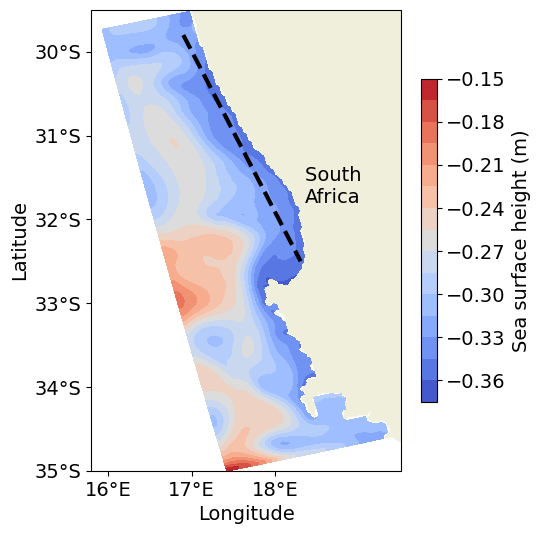

In [307]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


ax.set_extent([15.8, 19.5, -35.0, -29.5], crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(16, 19, 1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-35, -29.5, 1), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  

ax.add_feature(cfeature.LAND)

colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

edges_coord = []

# # water depth
# ca = da_sub.z.plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(), add_colorbar=False, alpha=0.5)
# cbar = fig.colorbar(ca, ax=ax, label='Depth (m)', orientation='vertical', shrink=0.7)

#     # contour
# contours = ax.contour(da_3km.lon_rho, da_3km.lat_rho, da_3km.isel(time=0).h, 
#                       levels=5, colors='black', linewidths=1.5, alpha=0.8)
# plt.clabel(contours, inline=True, fontsize=9)


# # edges
# corners_long = [tlong[0, 0], tlong[0, -1], tlong[-1, -1], tlong[-1, 0], tlong[0, 0]]
# corners_lat = [tlat[0, 0], tlat[0, -1], tlat[-1, -1], tlat[-1, 0], tlat[0, 0]]
# ax.plot(corners_long, corners_lat, '--', color='C3', alpha=0.7, )

#ax.legend(loc='lower left', fontsize=10)

ax.text(18.35, -31.8, 'South \nAfrica')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.plot(xtransect,ytransect,'k--', linewidth=3)

msk = da_3km.mask_rho.values
msk[msk == 0] = np.nan
ca = ax.contourf(tlong, tlat, da_3km.zeta.isel(time=0) * msk, levels=15, cmap=cm.coolwarm)
fig.colorbar(ca, ax=ax, label='Sea surface height (m)', orientation='vertical', shrink=0.7)

fig.savefig(f'./GRL_figures/GRL_figure_S1.png', bbox_inches='tight', dpi=200)

# Figure S4

In [309]:
# mean and std of MLD
var_name = 'MLD_N2'
var_data = (whole_ds_1poly100m[var_name]*inshore_mask)
var_data = xr.where(var_data==0, np.nan, var_data)  # convert 0 to nans
var_data = var_data.mean(dim=['eta_rho', 'xi_rho'])
MLD_mean =  var_data.groupby('time.month').mean(dim='time')
MLD_std =  var_data.groupby('time.month').std(dim='time')

In [319]:
#### linear regression
Tres_diff_100m = (whole_ds_1poly100m_noMLD-whole_ds_1poly100m).efold_time_int.isel(eta_rho=109, xi_rho=71)
mld = var_data

from scipy.stats import linregress

x = mld.values
y = Tres_diff_100m.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

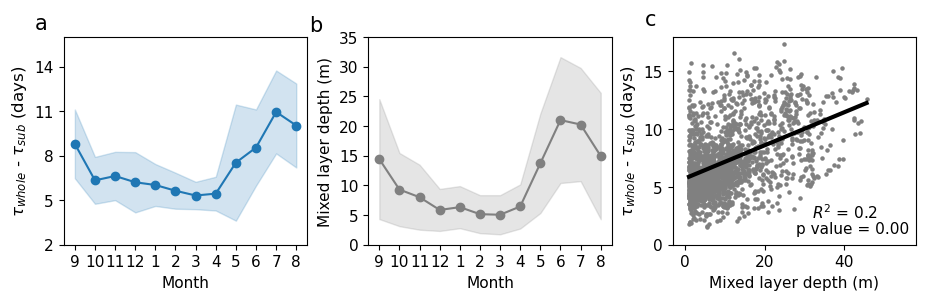

In [338]:
plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(1,3, figsize=(11, 2.7))

axes[0].plot(mean_diff_100m['month'], reorder(mean_diff_100m), marker='o', label='$\Delta_{Whole-bottom}$', color='C0')
axes[0].fill_between(mean_diff_100m['month'], reorder(mean_diff_100m) - reorder(std_diff_100m), reorder(mean_diff_100m) + reorder(std_diff_100m), alpha=0.2, color='C0')

axes[1].plot(MLD_mean['month'], reorder(MLD_mean), marker='o', label='MLD', color='gray')
axes[1].fill_between(MLD_mean['month'], reorder(MLD_mean) - reorder(MLD_std), reorder(MLD_mean) + reorder(MLD_std), alpha=0.2, color='gray')


axes[0].set_xlabel('Month')
axes[1].set_xlabel('Month')
axes[0].set_ylabel(r"$\tau_{whole}$ - $\tau_{sub}$ (days)", fontsize=12)
axes[1].set_ylabel('Mixed layer depth (m)')

axes[0].set_ylim(2,16)
axes[1].set_ylim(0,16)
axes[0].set_xticks(np.arange(1,13), string_numbers)
axes[1].set_xticks(np.arange(1,13),  string_numbers);
axes[0].set_yticks(np.arange(2,17,3));
axes[1].set_yticks(np.arange(0,36,5));


# Create scatter plot
axes[2].scatter(x, y, label='Data Points', s=5, c='gray')

# Plot regression line
x_range = np.linspace(min(x), max(x), 100)
y_pred = slope * x_range + intercept
axes[2].plot(x_range, y_pred, color='k', linewidth=3)

# Add labels and legend
axes[2].set_xlabel('Mixed layer depth (m)')
axes[2].set_ylabel(r"$\tau_{whole}$ - $\tau_{sub}$ (days)", fontsize=12)


# Display regression equation, R^2, and p-value
equation = f'y = {slope:.1f}x + {intercept:.1f}'
r_squared = f'$R^2$ = {r_value**2:.1f}'
p_val = f'p value = {p_value:.2f}'
#axes[2].text(30, 3.4, equation, fontsize=10)
axes[2].text(32, 2.3, r_squared)
axes[2].text(28, 1, p_val)

axes[2].set_xlim(-3, 58)
axes[2].set_ylim(0, 18)

plt.subplots_adjust(wspace=0.25, hspace=0.0)

axes[0].text(-1, 16.5, 'a' , fontsize=15)
axes[1].text(-2.5, 36, 'b', fontsize=15      )
axes[2].text(-10, 19, 'c', fontsize=15)

fig.savefig(f'./GRL_figures/GRL_figure_S4.png', bbox_inches='tight', dpi=200)

# Figure 2

In [350]:
da = xr.open_mfdataset('/d1/mengyang/Benguela/Particle_tracking/output_1km/avg_Y2012.nc')

tlong = da.lon_rho.values
tlat = da.lat_rho.values
mask = da.mask_rho.isel(time=0).values
inshore_mask = xr.where(da.isel(time=0).h <= 100, 1, 0)  # inshore of 100m
mask_sel = mask*inshore_mask

ocean_indices = np.where(mask_sel==1)
tlong_sel = tlong[ocean_indices]
tlat_sel = tlat[ocean_indices]

In [351]:
fpath = '/d1/mengyang/Benguela/Particle_tracking/tempdir/backward_watermass/'
ds_back = xr.open_dataset(fpath + 'back_15days_result_70m.nc')

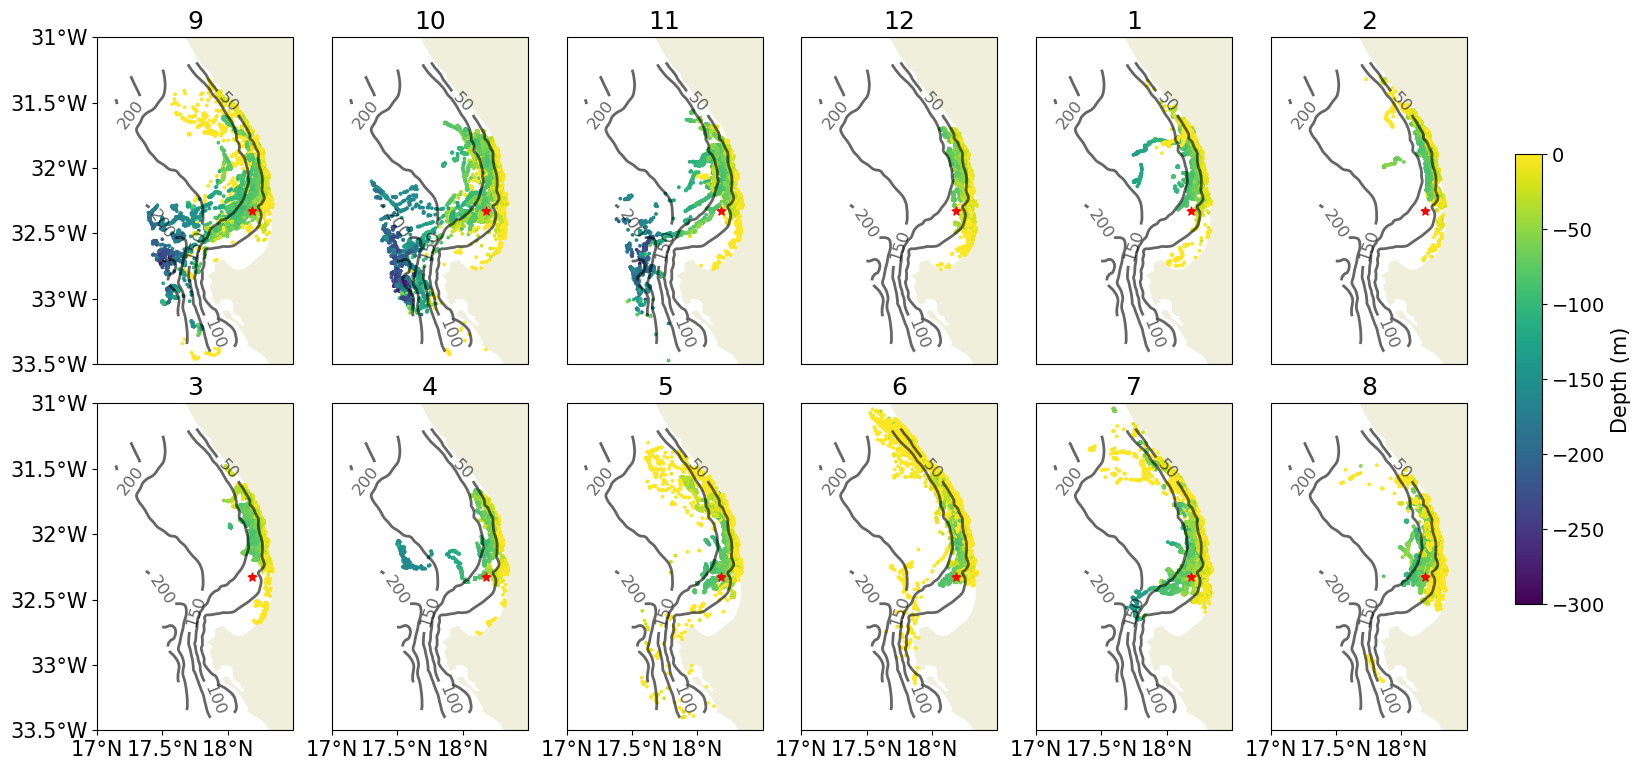

In [357]:
plt.rcParams.update({'font.size': 15})

order = [9,10,11,12,1,2,3,4,5,6,7,8]
fig = plt.figure(figsize=(18, 9))
for t in range(12):
    ax = fig.add_subplot(2, 6, t+1, projection=ccrs.PlateCarree())
    ax.set_extent([17, 18.5, -33.5, -31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    if t in [0,6]:
        ax.set_yticks(np.arange(-33.5, -30.5, 0.5), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=False)
        ax.yaxis.set_major_formatter(lon_formatter)  
    if t >= 6:
        ax.set_xticks(np.arange(17, 18.5, 0.5), crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lat_formatter)

    # contour
    contours = ax.contour(da.lon_rho, da.lat_rho, da.isel(time=0).h, 
                          levels=5, colors='black', linewidths=2, alpha=0.6, transform=ccrs.PlateCarree())
    plt.clabel(contours, inline=True, fontsize=12)

    #plt.contourf(tlong, tlat, da.zeta.isel(time=160), levels=15)
    #plt.colorbar(label='Sea surface height (m)')
    
    month = order[t]
    tim = f'{month}'
    ds_back_ = ds_back.sel(time=ds_back['time.month'] == month)
    plt.scatter(ds_back_.lon, ds_back_.lat, s=3, c=ds_back_.z, vmin=-300, vmax=0, cmap='viridis')
    #plt.colorbar(shrink=1, label='Depth (m)')
    plt.title(tim)

    # coordinate of 70 m mooring
    moor70m = [18.183, -32.329]
    moor20m = [18.318, -32.292]
    plt.scatter(moor70m[0], moor70m[1], s=40, marker='*',c='r')
    
#     # edges
#     corners_long = [tlong[0, 0], tlong[0, -1], tlong[-1, -1], tlong[-1, 0], tlong[0, 0]]
#     corners_lat = [tlat[0, 0], tlat[0, -1], tlat[-1, -1], tlat[-1, 0], tlat[0, 0]]
#     ax.plot(corners_long, corners_lat, '--', color='C3', alpha=0.7, )


def add_colorbar(x0, y0, vmin, vmax, label, cmap_label="viridis"):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar'
    '''
    cax = fig.add_axes([x0, y0, 0.015, 0.5])  # [x0, y0, width, height]
    cmap = plt.colormaps[cmap_label]
    normalize = plt.Normalize(vmin=vmin, vmax=vmax)  # Normalize the color values
    sm = cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = fig.colorbar(sm, cax=cax, shrink=0.9, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=14)

add_colorbar(0.92, 0.25, -300, 0, 'Depth (m)')
plt.subplots_adjust(wspace=0.06, hspace=0.12)

fig.savefig(f'./GRL_figures/GRL_figure_2.png', bbox_inches='tight', dpi=200)